# NLP task - classifying tweets as disaster tweets, or not

**Load the packages**

In [109]:
import pandas as pd
import re
import seaborn as sns 

**Import Data**

In [110]:
#Import the data
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

Inspect Train Data

There is a fairly even split of the target variable which is promising

<Axes: xlabel='target', ylabel='count'>

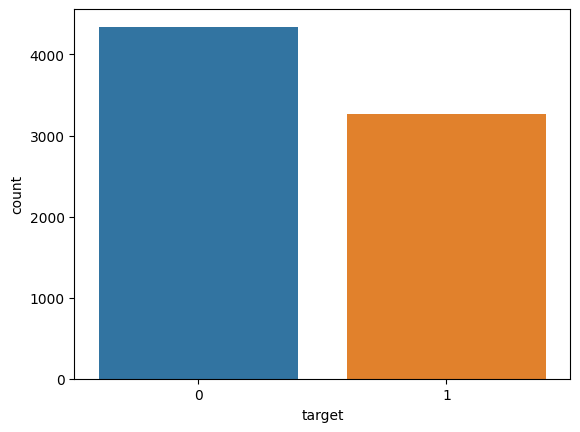

In [111]:
sns.countplot(train_data,x='target')

In [112]:
train_data.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [113]:
train_data['target'].unique()

array([1, 0])

Inspect Test Data

In [114]:
test_data.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [115]:
train_data['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

# Prepare Data For Cleansing

In [116]:
train_data['data_set'] = 'train'
test_data['data_set'] = 'test'

In [117]:
full_data = pd.concat([train_data, test_data], axis=0)
full_data.head(3)

,id,keyword,location,text,target,data_set
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,train
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,train
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,train


**Data Cleaning**

In [118]:
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [124]:
def data_cleaning(df):
    df = df.fillna('')
    df['text'] = df['text'].str.strip()
    df['text'] = df['text'].str.lower().replace('  ',' ')
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z ]|\b\d+\b', '', x))
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    return df

data_cleaned = data_cleaning(full_data)

In [128]:
data_cleaned.head(3)

,id,keyword,location,text,target,data_set,text_stemmed
0,1,,,deeds reason earthquake may allah forgive us,1.0,train,deed reason earthquak may allah forgiv us
1,4,,,forest fire near la ronge sask canada,1.0,train,forest fire near la rong sask canada
2,5,,,residents asked shelter place notified officer...,1.0,train,resid ask shelter place notifi offic evacu she...


# Stemming

Having cleaned the data, I will attempt stemming\
This will transform each word into it's root form

I will also keep the original text data, to see if stemming improves the model or not

**This tokenises and stemms at the same time**

In [176]:
from nltk.stem.porter import PorterStemmer

In [177]:
porter = PorterStemmer()

def tokeniser_porter(text):
    return ' '.join([porter.stem(word) for word in text.split()])

data_cleaned['text_stemmed'] = data_cleaned['text'].apply(tokeniser_porter)

In [178]:
data_cleaned.head(3)

,id,keyword,location,text,target,data_set,text_stemmed
0,1,,,deeds reason earthquake may allah forgive us,1.0,train,deed reason earthquak may allah forgiv us
1,4,,,forest fire near la ronge sask canada,1.0,train,forest fire near la rong sask canada
2,5,,,residents asked shelter place notified officer...,1.0,train,resid ask shelter place notifi offic evacu she...


# Split into train data and evaluation data

In [84]:
import numpy as np
from sklearn.model_selection import train_test_split

In [133]:
train_data = data_cleaned[data_cleaned['data_set'] =='train']
train_data['target'] = train_data['target'].astype(int) 

evaluation_data = data_cleaned[data_cleaned['data_set'] =='test']

Want to test the stemmed and non stemmed data

In [134]:
train_stem = train_data[['id','keyword','location','text_stemmed','target']]
train_non_stem = train_data[['id','keyword','location','text','target']]

In [87]:
#X_train = [str(text) if isinstance(text, (str, np.unicode_)) else '' for text in X_train]

# Modelling

**Logistic Regression - non-stemmed**
- I am using a Tfid vectorizer
- this vectorizes the text - ie assigns values to each word so that I can begin modelling
- and assigns values to words based on how often that words appears in the dataset as a whole - that way unique words are more significant 

In [135]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

**Tfidf Vectoriser**

In [182]:
vectorizer = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

log_r_ns = Pipeline([
                            ('vect',vectorizer),
                            ('clf', LogisticRegression())
                         ])

X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(train_non_stem['text'], train_non_stem['target'], test_size=0.2, random_state=42)

log_r_ns.fit(X_train_ns, y_train_ns)
y_pred_train_log_r_ns = log_r_ns.predict(X_train_ns) 
y_pred_test_log_r_ns = log_r_ns.predict(X_test_ns)

score_train = accuracy_score(y_train_ns,y_pred_train_log_r_ns)
print(score_train)

score_test = accuracy_score(y_test_ns,y_pred_test_log_r_ns)
print(score_test)

0.9018062397372743
0.793827971109652


**Count Vectoriser**

The warnings for this code are unecessary - I have removed

In [138]:
import warnings
warnings.filterwarnings('ignore')

In [183]:
vectorizer = CountVectorizer()

log_r_ns = Pipeline([
                            ('vect',vectorizer),
                            ('clf', LogisticRegression())
                         ])

X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(train_non_stem['text'], train_non_stem['target'], test_size=0.2, random_state=42)

log_r_ns.fit(X_train_ns, y_train_ns)
y_pred_train_log_r_ns = log_r_ns.predict(X_train_ns) 
y_pred_test_log_r_ns = log_r_ns.predict(X_test_ns)

score_train = accuracy_score(y_train_ns,y_pred_train_log_r_ns)
print(score_train)

score_test = accuracy_score(y_test_ns,y_pred_test_log_r_ns)
print(score_test)

0.9725779967159277
0.7925147734734077


**Stemmed**

Performance on the test dat is marginally worse compared to the stemmed data

**Tfidf**

In [184]:
vectorizer = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

log_r_s = Pipeline([
                            ('vect',vectorizer),
                            ('clf', LogisticRegression())
                         ])

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(train_stem['text_stemmed'], train_stem['target'], test_size=0.2, random_state=42)

log_r_s.fit(X_train_s, y_train_s)
y_pred_train_log_r_s = log_r_s.predict(X_train_s) 
y_pred_test_log_r_s = log_r_s.predict(X_test_s)

score_train = accuracy_score(y_train_s,y_pred_train_log_r_s)
print(score_train)

score_test = accuracy_score(y_test_s,y_pred_test_log_r_s)
print(score_test)

0.8944170771756978
0.7931713722915299


**Count Vectoriser**

In [185]:
vectorizer = CountVectorizer()

log_r_s = Pipeline([
                            ('vect',vectorizer),
                            ('clf', LogisticRegression())
                         ])

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(train_stem['text_stemmed'], train_stem['target'], test_size=0.2, random_state=42)

log_r_s.fit(X_train_s, y_train_s)
y_pred_train_log_r_s = log_r_s.predict(X_train_s) 
y_pred_test_log_r_s = log_r_s.predict(X_test_s)

score_train = accuracy_score(y_train_s,y_pred_train_log_r_s)
print(score_train)

score_test = accuracy_score(y_test_s,y_pred_test_log_r_s)
print(score_test)

0.9663382594417077
0.7905449770190414


**Grid Search - 5 Fold Cross Validation**

- The LogR model is performing best on the non stemmed data with count vectorizer, I will try and improve the performance of the model using a grid search

In [142]:
from sklearn.model_selection import GridSearchCV

In [186]:
paramater_grid = [
    {'clf__penalty': ['l2','l1'],
        'clf__C': [0.1, 1, 10],
         'clf__max_iter': [80]
    }
]

vectorizer = CountVectorizer()

log_r_s = Pipeline([
                            ('vect',vectorizer),
                            ('clf', LogisticRegression())
                         ])

gs_tfidf = GridSearchCV(log_r_s,
                        paramater_grid,
                        scoring='accuracy',
                        cv=5,
                        verbose=2,
                        n_jobs=1)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(train_stem['text_stemmed'], train_stem['target'], test_size=0.2, random_state=42)

gs_tfidf.fit(X_train_s, y_train_s)

y_pred_train_gs_s = gs_tfidf.predict(X_train_s)
y_pred_test_gs_s = gs_tfidf.predict(X_test_s)

score_train = accuracy_score(y_train_s,y_pred_train_gs_s)
print(score_train)

score_test = accuracy_score(y_test_s,y_pred_test_gs_s)
print(score_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......clf__C=0.1, clf__max_iter=80, clf__penalty=l2; total time=   0.3s
[CV] END ......clf__C=0.1, clf__max_iter=80, clf__penalty=l2; total time=   0.3s
[CV] END ......clf__C=0.1, clf__max_iter=80, clf__penalty=l2; total time=   0.3s
[CV] END ......clf__C=0.1, clf__max_iter=80, clf__penalty=l2; total time=   0.3s
[CV] END ......clf__C=0.1, clf__max_iter=80, clf__penalty=l2; total time=   0.4s
[CV] END ......clf__C=0.1, clf__max_iter=80, clf__penalty=l1; total time=   0.1s
[CV] END ......clf__C=0.1, clf__max_iter=80, clf__penalty=l1; total time=   0.1s
[CV] END ......clf__C=0.1, clf__max_iter=80, clf__penalty=l1; total time=   0.1s
[CV] END ......clf__C=0.1, clf__max_iter=80, clf__penalty=l1; total time=   0.1s
[CV] END ......clf__C=0.1, clf__max_iter=80, clf__penalty=l1; total time=   0.1s
[CV] END ........clf__C=1, clf__max_iter=80, clf__penalty=l2; total time=   0.6s
[CV] END ........clf__C=1, clf__max_iter=80, clf_

In [144]:
gs_tfidf.best_params_

{'clf__C': 1, 'clf__max_iter': 80, 'clf__penalty': 'l2'}

In [145]:
print(score_train)
print(score_test)

0.9663382594417077
0.7905449770190414


**Naive Bayes - non stemmed**

**Tfidf**

In [146]:
from sklearn.naive_bayes import MultinomialNB

In [187]:
vectorizer = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

mnb_pipe_ns = Pipeline([
                            ('vect',vectorizer),
                            ('mnb', MultinomialNB())
                         ])

X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(train_non_stem['text'], train_non_stem['target'], test_size=0.2, random_state=42)

mnb_pipe_ns.fit(X_train_ns, y_train_ns)
y_pred_train_mnb_ns = mnb_pipe_ns.predict(X_train_ns) 
y_pred_test_mnb_ns = mnb_pipe_ns.predict(X_test_ns)

score_train = accuracy_score(y_train_ns,y_pred_train_mnb_ns)
print(score_train)

score_test = accuracy_score(y_test_ns,y_pred_test_mnb_ns)
print(score_test)

0.9137931034482759
0.7984241628365069


Model performance is improving still - lets try another few models

**Count Vectoriser**

In [188]:
vectorizer = CountVectorizer()

mnb_pipe_ns = Pipeline([
                            ('vect',vectorizer),
                            ('mnb', MultinomialNB())
                         ])

X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(train_non_stem['text'], train_non_stem['target'], test_size=0.2, random_state=42)

mnb_pipe_ns.fit(X_train_ns, y_train_ns)
y_pred_train_mnb_ns = mnb_pipe_ns.predict(X_train_ns) 
y_pred_test_mnb_ns = mnb_pipe_ns.predict(X_test_ns)

score_train = accuracy_score(y_train_ns,y_pred_train_mnb_ns)
print(score_train)

score_test = accuracy_score(y_test_ns,y_pred_test_mnb_ns)
print(score_test)

0.9318555008210181
0.7931713722915299


**Naive Bayes - stemmed**

**Tfidf Vectoriser**

In [189]:
vectorizer = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

mnb_pipe_s = Pipeline([
                            ('vect',vectorizer),
                            ('mnb', MultinomialNB())
                         ])

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(train_stem['text_stemmed'], train_stem['target'], test_size=0.2, random_state=42)

mnb_pipe_s.fit(X_train_s, y_train_s)
y_pred_train_mnb_s = mnb_pipe_s.predict(X_train_s) 
y_pred_test_mnb_s = mnb_pipe_s.predict(X_test_s)

score_train = accuracy_score(y_train_s,y_pred_train_mnb_s)
print(score_train)

score_test = accuracy_score(y_test_s,y_pred_test_mnb_s)
print(score_test)

0.906568144499179
0.799080761654629


**Count Vectoriser**

In [200]:
vectorizer = CountVectorizer()

mnb_pipe_s = Pipeline([
                            ('vect',vectorizer),
                            ('mnb', MultinomialNB())
                         ])

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(train_stem['text_stemmed'], train_stem['target'], test_size=0.2, random_state=42)

mnb_pipe_s.fit(X_train_s, y_train_s)
y_pred_train_mnb_s = mnb_pipe_s.predict(X_train_s) 
y_pred_test_mnb_s = mnb_pipe_s.predict(X_test_s)

score_train = accuracy_score(y_train_s,y_pred_train_mnb_s)
print(score_train)

score_test = accuracy_score(y_test_s,y_pred_test_mnb_s)
print(score_test)

0.9226600985221675
0.8017071569271176


Best performance so far

**Naive Bayes - Stemmed - 5 Fold Cross Validation - Grid Search**

In [192]:
# This converts words to numbers and downweights words that appear in most messages
vectorizer = CountVectorizer()

# This sets up a pipeline to apply the vectoriser and the model
mnb_pipe_s = Pipeline([
                            ('vect',vectorizer),
                            ('mnb', MultinomialNB())
                         ])

# This sets the parameters we want to test on the model
mnb_params = [
    {'mnb__alpha': [0.1, 1, 10],
     'mnb__fit_prior':[True,False]
    }
]

# This applies the grid search method
gs_tfidf_nb_s = GridSearchCV(mnb_pipe_s,
                        mnb_params,
                        scoring='accuracy',
                        cv=5,
                        verbose=2,
                        n_jobs=1)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(train_stem['text_stemmed'], train_stem['target'], test_size=0.2, random_state=42)

gs_tfidf_nb_s.fit(X_train_s, y_train_s)

y_pred_train_gs_mnb = gs_tfidf.predict(X_train_s)
y_pred_test_gs_mnb = gs_tfidf.predict(X_test_s)

score_train = accuracy_score(y_train_s,y_pred_train_gs_mnb)
print(score_train)

score_test = accuracy_score(y_test_s,y_pred_test_gs_mnb)
print(score_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ................mnb__alpha=0.1, mnb__fit_prior=True; total time=   0.1s
[CV] END ................mnb__alpha=0.1, mnb__fit_prior=True; total time=   0.1s
[CV] END ................mnb__alpha=0.1, mnb__fit_prior=True; total time=   0.1s
[CV] END ................mnb__alpha=0.1, mnb__fit_prior=True; total time=   0.1s
[CV] END ................mnb__alpha=0.1, mnb__fit_prior=True; total time=   0.1s
[CV] END ...............mnb__alpha=0.1, mnb__fit_prior=False; total time=   0.1s
[CV] END ...............mnb__alpha=0.1, mnb__fit_prior=False; total time=   0.1s
[CV] END ...............mnb__alpha=0.1, mnb__fit_prior=False; total time=   0.1s
[CV] END ...............mnb__alpha=0.1, mnb__fit_prior=False; total time=   0.1s
[CV] END ...............mnb__alpha=0.1, mnb__fit_prior=False; total time=   0.1s
[CV] END ..................mnb__alpha=1, mnb__fit_prior=True; total time=   0.1s
[CV] END ..................mnb__alpha=1, mnb__fit

The model performance is actually worse, this is most likely due to the 5 fold cross validation

**XGBoost**

In [150]:
import xgboost as xgb

In [193]:
vectorizer = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

xgb_ns = Pipeline([
                            ('vect',vectorizer),
                            ('xgb', xgb.XGBClassifier())
                         ])

X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(train_non_stem['text'], train_non_stem['target'], test_size=0.2, random_state=42)

xgb_ns.fit(X_train_ns, y_train_ns)
y_pred_train_xgb_ns = xgb_ns.predict(X_train_ns) 
y_pred_test_xgb_ns = xgb_ns.predict(X_test_ns)

score_train = accuracy_score(y_train_ns,y_pred_train_xgb_ns)
print(score_train)

score_test = accuracy_score(y_test_ns,y_pred_test_xgb_ns)
print(score_test)

0.8536945812807881
0.757715036112935


**Random Forest**

In [194]:
from sklearn.ensemble import RandomForestClassifier

In [196]:
vectorizer = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

rfc_ns = Pipeline([
                            ('vect',vectorizer),
                            ('rfc', RandomForestClassifier())
                         ])

X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(train_non_stem['text'], train_non_stem['target'], test_size=0.2, random_state=42)

rfc_ns.fit(X_train_ns, y_train_ns)
y_pred_train_rfc_ns = rfc_ns.predict(X_train_ns) 
y_pred_test_rfc_ns = rfc_ns.predict(X_test_ns)

score_train = accuracy_score(y_train_ns,y_pred_train_rfc_ns)
print(score_train)

score_test = accuracy_score(y_test_ns,y_pred_test_rfc_ns)
print(score_test)

0.9967159277504105
0.7662508207485227


# Build My Own Ensemble Model - using the best performing MNB model and best Logistic Regression Model

This averages the predictions of my MNB and LogisticRegression model

In [202]:
from sklearn.ensemble import VotingClassifier
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(train_stem['text_stemmed'], train_stem['target'], test_size=0.2, random_state=42)
ensemble_model = VotingClassifier(estimators=[('mnb', mnb_pipe_s), ('lr', log_r_s)], voting='hard')
ensemble_model.fit(X_train_s,y_train_s)
ensemble_model.score(X_test_s,y_test_s)

0.8036769533814839

This isnt performing as well as the models above

# Submission

Having tested a variety of model types, including building my own ensemble model, I am happy with the results and will apply the best performing models to the evaluation data

**MNB Submission**

In [201]:
pred_target = mnb_pipe_s.predict(evaluation_data['text_stemmed'])

to_submit = pd.DataFrame({
    'id':evaluation_data['id'],
    'target':pred_target
})

In [199]:
to_submit.to_csv('submission.csv',index=False)

**The ensemble I built also performed well**

In [203]:
pred_target = ensemble_model.predict(evaluation_data['text_stemmed'])

to_submit = pd.DataFrame({
    'id':evaluation_data['id'],
    'target':pred_target
})

In [204]:
to_submit.to_csv('submission.csv',index=False)

This model performs best against the evaluation data